In [1]:
pip install waterfallcharts

Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np
from pandasql import sqldf
pd.options.display.max_columns = 1000000
pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
from scipy.stats import skew
import matplotlib.ticker
from datetime import datetime, timedelta
import waterfall_chart
import seaborn as sns
from scipy import stats

In [3]:
trades = pd.read_csv('trades.csv')
events = pd.read_csv('events.csv')
referrals = pd.read_csv('referrals.csv')
split_test_exposures = pd.read_csv('split_test_exposures.csv')

3.0 Monthly Cumulative Signed Up Referree


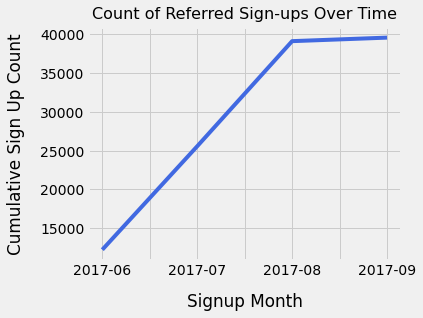

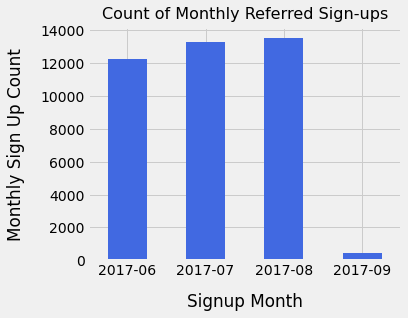

In [39]:
print("3.0 Monthly Cumulative Signed Up Referree");
# sqldf('select date(referree_signup_date) as dt, count(referree_user_id) as cnt from referrals group by 1 order by 1')
monthly=referrals.groupby(referrals.referree_signup_date.str[0:7])['referree_user_id'].count().reset_index(name='cnt')
monthly['cumulative']=monthly['cnt'].cumsum();

monthly.plot(kind='line', x='referree_signup_date', y='cumulative', 
        figsize=(5, 4), legend=False, color='royalblue', rot=0);
plt.title("Count of Referred Sign-ups Over Time", y=1.01, fontsize=16)
plt.ylabel("Cumulative Sign Up Count", labelpad=15)
plt.xlabel("Signup Month", labelpad=15);

monthly.plot(kind='bar', x='referree_signup_date', y='cnt', 
        figsize=(5, 4), legend=False, color='royalblue', rot=0);
plt.title("Count of Monthly Referred Sign-ups", y=1.01, fontsize=16)
plt.ylabel("Monthly Sign Up Count", labelpad=15)
plt.xlabel("Signup Month", labelpad=15);

In [5]:
monthly

,referree_signup_date,cnt,cumulative
0,2017-06,12241,12241
1,2017-07,13317,25558
2,2017-08,13530,39088
3,2017-09,454,39542


In [6]:
print("3.1 Pivot table for sign-up vs trading")
refer_trade=sqldf("""select substr(referree_signup_date,0,8) as month
                     ,case when b.user_id is null then 0 else 1 end as trade
                     ,count(distinct a.referree_user_id) as cnt 
                     from referrals a 
                          left join trades b 
                          on a.referree_user_id=b.user_id 
                     group by 1,2 
                     order by 1""");
refer_trade['cumulative']=refer_trade.groupby(['trade'])['cnt'].cumsum();
refer_trade

3.1 Pivot table for sign-up vs trading


,month,trade,cnt,cumulative
0,2017-06,0,11138,11138
1,2017-06,1,1103,1103
2,2017-07,0,12161,23299
3,2017-07,1,1156,2259
4,2017-08,0,12467,35766
5,2017-08,1,1063,3322
6,2017-09,0,427,36193
7,2017-09,1,27,3349


In [7]:
print("3.1 Same result as sql")
trade_customer=trades['user_id'].value_counts().rename_axis('user_id').reset_index(name='freq')
refer_trade2=pd.merge(referrals,trade_customer,left_on='referree_user_id',right_on='user_id',how='left')
refer_trade2.loc[refer_trade2.user_id.isna(),'trade']=0
refer_trade2.loc[refer_trade2.user_id.notna(),'trade']=1
refer_trade3=refer_trade2.groupby([referrals.referree_signup_date.str[0:7],'trade'])['referree_user_id'].count().reset_index(name='cnt')
refer_trade3['cumulative']=refer_trade3.groupby(['trade'])['cnt'].cumsum();
refer_trade3

3.1 Same result as sql


,referree_signup_date,trade,cnt,cumulative
0,2017-06,0.0,11138,11138
1,2017-06,1.0,1103,1103
2,2017-07,0.0,12161,23299
3,2017-07,1.0,1156,2259
4,2017-08,0.0,12467,35766
5,2017-08,1.0,1063,3322
6,2017-09,0.0,427,36193
7,2017-09,1.0,27,3349


In [8]:
# 3.2 pivot of sign-up and trading
pd.pivot_table(refer_trade,index=['month'],values=['cnt','cumulative'],
               columns=['trade'])

cnt       cumulative      
trade        0     1          0     1
month                                
2017-06  11138  1103      11138  1103
2017-07  12161  1156      23299  2259
2017-08  12467  1063      35766  3322
2017-09    427    27      36193  3349

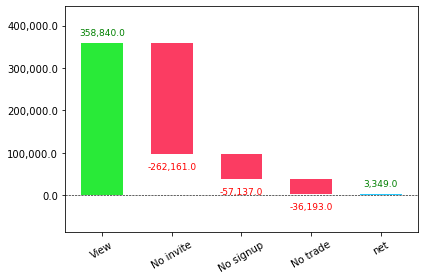

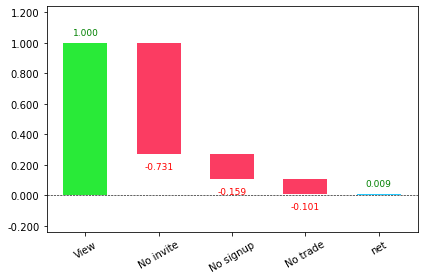

In [9]:
# 3.3 referral funnel anlaysis waterfall
view_cnt=events[events.event_type=='referrer_page_viewed']['user_id'].count()
invite_cnt=events[events.event_type=='referrer_page_invite_action']['user_id'].count()
sign_up_cnt=referrals['referree_user_id'].count()
trade_cnt=refer_trade2[refer_trade2.trade==1]['user_id'].count()
a=['View','No invite','No signup','No trade']
b=[view_cnt,-view_cnt+invite_cnt,-invite_cnt+sign_up_cnt,-sign_up_cnt+trade_cnt]
c=[1,(-view_cnt+invite_cnt)/view_cnt,(-invite_cnt+sign_up_cnt)/view_cnt,(-sign_up_cnt+trade_cnt)/view_cnt]

waterfall_chart.plot(a, b);
waterfall_chart.plot(a, c,formatting='{:,.3f}');

In [10]:
freq=sqldf('select referrer_user_id,count(*) as freq from referrals group by 1 order by 2 desc')
freq.describe(percentiles=[.05,.1,.25, .5, .75,.85,.95,.97,.98,.99])

,freq
count,10388.000000
mean,3.806508
std,49.277508
min,1.000000
5%,1.000000
10%,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
85%,2.000000


3.4 In the customers who have made signed-up referrals, the distribution of referrals frequency from 06/02/2017 to 09/012017  looks as below. The medium value of the frequency is 1 and maximum value is 2997. Around 95% of referrers made <=5 signed up referrals and 83% of referred only made one referral. 


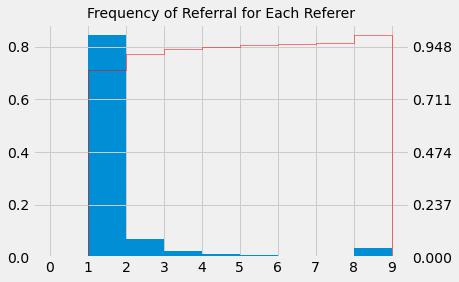

In [40]:
print("3.4 In the customers who have made signed-up referrals, the distribution of referrals frequency from 06/02/2017 to 09/012017  looks as below. The medium value of the frequency is 1 and maximum value is 2997. Around 95% of referrers made <=5 signed up referrals and 83% of referred only made one referral. ");
freq['freq'].clip(lower=0, upper=9, inplace=True)    
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()
plt.xticks(np.arange(0,10,1))
ax.hist(freq.freq, bins=range(0, 10, 1), density=True)
ax1=ax.twinx() 
ax1.hist(freq.freq, bins=range(0,10, 1), density=True, histtype='step', cumulative=1 ,color='red')
plt.title("Frequency of Referral for Each Referer",fontsize=14)
l = ax.get_ylim()
l1 = ax1.get_ylim()
f = lambda x : l1[0]+(x-l[0])/(l[1]-l[0])*(l1[1]-l1[0])
ticks = f(ax.get_yticks())
ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
plt.show(); 

In [12]:
print("4.1 Data Cleaning: around 2.9% of data are assigned to two different groups");
# sqldf('select user_id, count(*) as cnt from split_test_exposures group by 1 having count(*)>1')
dup=split_test_exposures[split_test_exposures.user_id.duplicated()==True]
print(dup.user_id.nunique(),split_test_exposures.user_id.nunique(), dup.user_id.nunique()/split_test_exposures.user_id.nunique())


4.1 Data Cleaning: around 2.9% of data are assigned to two different groups
5214 182456 0.02857675275134827


In [13]:
dup.sort_values(by=['user_id']).head(5)

,user_id,split_test_name,split_test_group,exposed_time
145752,0003b2b281804114a6bd8235ba9cbff8,ios_referral_experiment,tab_only,2017-07-28 01:14:37.180000
177449,00188e82e67385c56715363e03e28331,ios_referral_experiment,tab_only,2017-07-28 03:22:45.643000
174832,001b9fe6cc897968a5078d1340738900,ios_referral_experiment,tab_only,2017-07-28 23:32:09.668000
75122,003426e0f7b6d6736c722d87cd5dbdb1,ios_referral_experiment,tab_only,2017-07-31 10:00:05.322000
168934,005446a9f6e60160e4f87231d8f6db4a,ios_referral_experiment,tab_only,2017-07-28 08:14:27.658000


In [14]:
print("spot check")
split_test_exposures[split_test_exposures.user_id=='00188e82e67385c56715363e03e28331']  

spot check


,user_id,split_test_name,split_test_group,exposed_time
141644,00188e82e67385c56715363e03e28331,ios_referral_experiment,tab_settings,2017-07-17 00:56:35.692000
177449,00188e82e67385c56715363e03e28331,ios_referral_experiment,tab_only,2017-07-28 03:22:45.643000


In [15]:
# dedup=split_test_exposures[split_test_exposures.user_id.duplicated()==False]
# above is different from drop_duplicates keep=false
exp_dedup=split_test_exposures.drop_duplicates(subset=['user_id'],keep=False)
exp_dedup.user_id.count()

177242

4.2 Daily and cumulative exposure chart


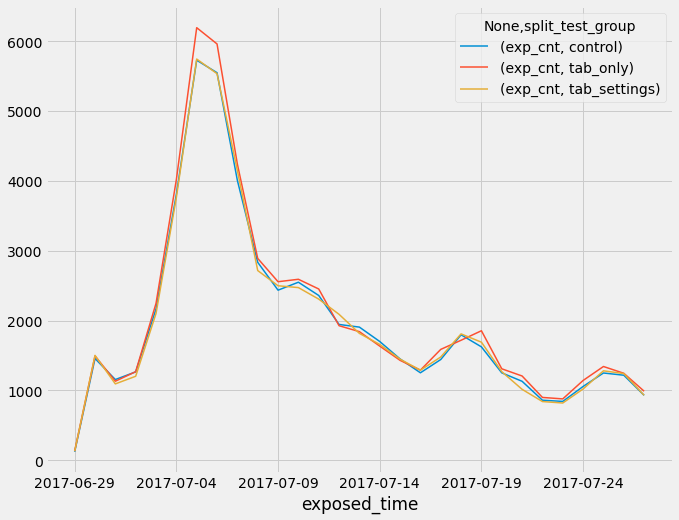

In [41]:
print("4.2 Daily and cumulative exposure chart")
exp_date=exp_dedup.groupby([exp_dedup.exposed_time.str[0:10],'split_test_group'])['user_id'].count().reset_index(name='exp_cnt')
exp_date['cumulative']=exp_date.groupby(['split_test_group'])['exp_cnt'].cumsum()
exp_date=exp_date[exp_date.exposed_time<'2017-07-28']
exp_pivot=exp_date.pivot(index='exposed_time',columns='split_test_group',values=['exp_cnt'])
exp_pivot.plot(figsize=(10, 8),linewidth=1.5)

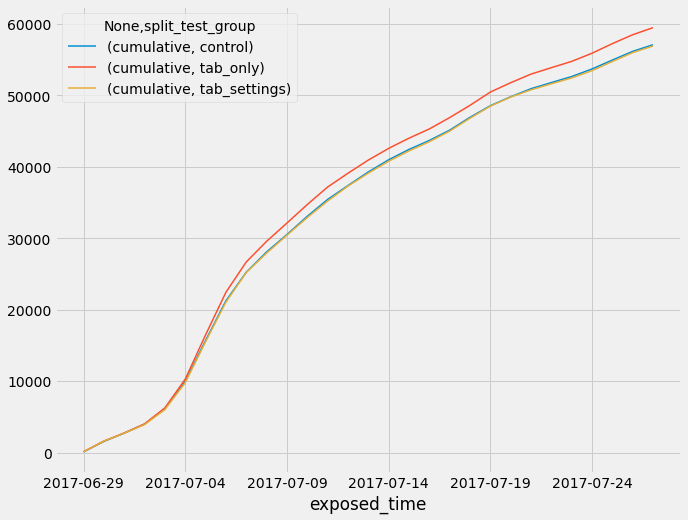

In [17]:
exp_pivot=exp_date.pivot(index='exposed_time',columns='split_test_group',values=['cumulative'])
exp_pivot.plot(figsize=(10, 8),linewidth=1.5)

Daily cumulative group %


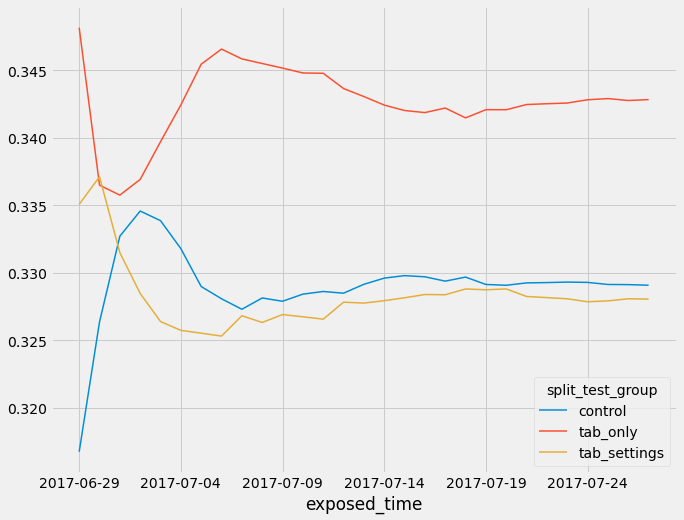

In [42]:
print("Daily cumulative group %")
cb=pd.crosstab(exp_date.exposed_time, exp_date.split_test_group, values=exp_date.cumulative, aggfunc=np.sum, normalize='index')
cb.plot(figsize=(10, 8),linewidth=1.5)

In [19]:
exp_dedup=exp_dedup[exp_dedup.exposed_time.str[0:10]<'2017-07-28']
exp_dedup.user_id.count()

173523

In [20]:
exp_dedup.split_test_name.value_counts()

ios_referral_experiment    173523
Name: split_test_name, dtype: int64

In [21]:
freq=sqldf('select referrer_user_id,count(*) as freq from referrals group by 1 order by 2 desc')
freq_outlier=freq[freq.freq>=42]
freq_outlier.head(10)

,referrer_user_id,freq
0,13bc7588a99ddb8b8a5bf210b6020639,2997
1,5e32a66341aca5f7644f8cdbc73a08c4,2828
2,a4c5a8bad1cbffe8f54d8e987d9b4f51,1548
3,8cfc99a18ee83bc3e080726039586c0f,1130
4,d4ebba15f94b332d90c5687004a98bda,1010
5,a28f0698f628c42acd06cf3ab02413f8,735
6,d4c7efaddf3cae4d76c913125052dec6,714
7,e2eb15e80569c6d44ce40fd52a0e926d,687
8,162288f84b2977d10dfd285c49163dbc,462
9,926486a0633d41e3e54708f194cd7e9c,451


In [22]:
exp_dedup[~exp_dedup.user_id.isin(freq_outlier.referrer_user_id)]['user_id'].count()

173523

In [44]:
print("add metrics value before and after experiment");

event_cnt=pd.merge(exp_dedup,events,left_on=['user_id'],right_on=['user_id'],how='left')
view_event=event_cnt[(event_cnt.event_type=='referrer_page_viewed')& 
                     (event_cnt.exposed_time<=event_cnt.event_time)& 
                     (event_cnt.platform=='iOS')].groupby(['user_id']).size().reset_index(name='view_cnt')
invite_event=event_cnt[(event_cnt.event_type=='referrer_page_invite_action')& 
                     (event_cnt.exposed_time<=event_cnt.event_time)& 
                     (event_cnt.platform=='iOS')].groupby(['user_id']).size().reset_index(name='invite_cnt')
pre_view_event=event_cnt[(event_cnt.event_type=='referrer_page_viewed')& 
                     (event_cnt.exposed_time>event_cnt.event_time)& 
                     (event_cnt.platform=='iOS')].groupby(['user_id']).size().reset_index(name='pre_view_cnt')
pre_invite_event=event_cnt[(event_cnt.event_type=='referrer_page_invite_action')& 
                     (event_cnt.exposed_time>event_cnt.event_time)& 
                     (event_cnt.platform=='iOS')].groupby(['user_id']).size().reset_index(name='pre_invite_cnt')

exp_result=pd.merge(exp_dedup,view_event,left_on=['user_id'],right_on=['user_id'],how='left')
exp_result=pd.merge(exp_result,invite_event,left_on=['user_id'],right_on=['user_id'],how='left')
exp_result=pd.merge(exp_result,pre_view_event,left_on=['user_id'],right_on=['user_id'],how='left')
exp_result=pd.merge(exp_result,pre_invite_event,left_on=['user_id'],right_on=['user_id'],how='left')

exp_result["view_to_invite_ratio"]=exp_result["invite_cnt"]/exp_result["view_cnt"]
exp_result=exp_result.fillna(0)
exp_result.head(5)


add metrics value before and after experiment


,user_id,split_test_name,split_test_group,exposed_time,view_cnt,invite_cnt,pre_view_cnt,pre_invite_cnt,view_to_invite_ratio
0,650be962eaef1648482b228babb28973,ios_referral_experiment,control,2017-06-29 18:37:01.890000,0.0,0.0,0.0,0.0,0.0
1,2c35e245e4f8bd07cd4239ee79cc3aed,ios_referral_experiment,tab_settings,2017-06-30 04:38:12.475000,1.0,0.0,0.0,0.0,0.0
2,bbb4ec386f36f3b1a6ccbaf8d656e940,ios_referral_experiment,tab_settings,2017-06-30 04:47:27.386000,1.0,0.0,0.0,0.0,0.0
3,2a825d1a475cf4671d6f8d8144a91989,ios_referral_experiment,tab_settings,2017-06-30 05:57:47.305000,0.0,0.0,0.0,0.0,0.0
4,e9c6689675964743bd4160f73ac19345,ios_referral_experiment,tab_only,2017-06-30 07:13:33.469000,1.0,0.0,0.0,0.0,0.0


In [24]:
#use sql to double check the total invite post experiments 
test=sqldf("""select count(b.user_id) as cnt
              from exp_dedup a 
              left join events b 
              on a.user_id=b.user_id
              and a.exposed_time<=b.event_time
              where b.event_type="referrer_page_invite_action"
              and b.platform=='iOS' """);
test

,cnt
0,4353


In [25]:
exp_result.invite_cnt.sum()


4353.0

In [26]:
exp_result.describe(include='all',percentiles=[.05,.1,.25, .5, .75,.85,.95,.97,.98,.99])

,user_id,split_test_name,split_test_group,exposed_time,view_cnt,invite_cnt,pre_view_cnt,pre_invite_cnt
count,173523,173523,173523,173523,173523.000000,173523.000000,173523.000000,173523.000000
unique,173523,1,3,173510,NaN,NaN,NaN,NaN
top,e078bde5dd9d13036dc912f71faabe8e,ios_referral_experiment,tab_only,2017-07-15 06:28:18.014000,NaN,NaN,NaN,NaN
freq,1,173523,59491,2,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.554612,0.025086,0.000784,0.000052
std,NaN,NaN,NaN,NaN,2.217209,0.496096,0.060916,0.009898
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
5%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
10%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [27]:
exp_result.head(5)

,user_id,split_test_name,split_test_group,exposed_time,view_cnt,invite_cnt,pre_view_cnt,pre_invite_cnt
0,650be962eaef1648482b228babb28973,ios_referral_experiment,control,2017-06-29 18:37:01.890000,0.0,0.0,0.0,0.0
1,2c35e245e4f8bd07cd4239ee79cc3aed,ios_referral_experiment,tab_settings,2017-06-30 04:38:12.475000,1.0,0.0,0.0,0.0
2,bbb4ec386f36f3b1a6ccbaf8d656e940,ios_referral_experiment,tab_settings,2017-06-30 04:47:27.386000,1.0,0.0,0.0,0.0
3,2a825d1a475cf4671d6f8d8144a91989,ios_referral_experiment,tab_settings,2017-06-30 05:57:47.305000,0.0,0.0,0.0,0.0
4,e9c6689675964743bd4160f73ac19345,ios_referral_experiment,tab_only,2017-06-30 07:13:33.469000,1.0,0.0,0.0,0.0


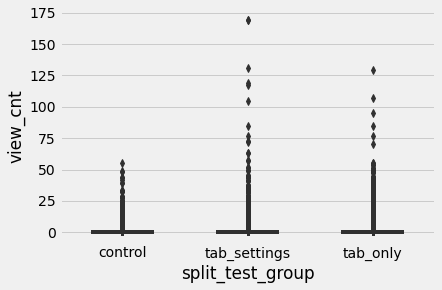

In [28]:
print("Boxplot of different groups metric of view")
sns.boxplot(y='view_cnt', x='split_test_group', 
                 data=exp_result, 
                 width=0.5,
                 palette="colorblind")

In [29]:
exp_result.groupby('split_test_group')[['view_cnt','invite_cnt']].describe(percentiles=[.5])

view_cnt                                      invite_cnt  \
                    count      mean       std  min  50%    max      count   
split_test_group                                                            
control           57105.0  0.332703  1.349403  0.0  0.0   55.0    57105.0   
tab_only          59491.0  0.707250  2.522148  0.0  0.0  129.0    59491.0   
tab_settings      56927.0  0.617703  2.536329  0.0  0.0  169.0    56927.0   

                                                       
                      mean       std  min  50%    max  
split_test_group                                       
control           0.013589  0.209882  0.0  0.0   14.0  
tab_only          0.031030  0.499061  0.0  0.0   74.0  
tab_settings      0.030407  0.667482  0.0  0.0  117.0

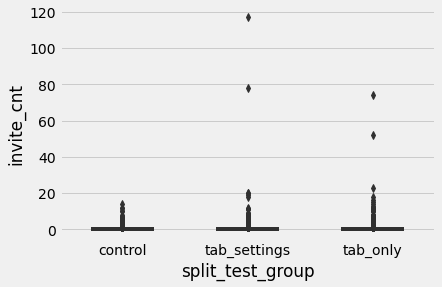

In [30]:
sns.boxplot(y='invite_cnt', x='split_test_group', 
                 data=exp_result, 
                 width=0.5,
                 palette="colorblind")

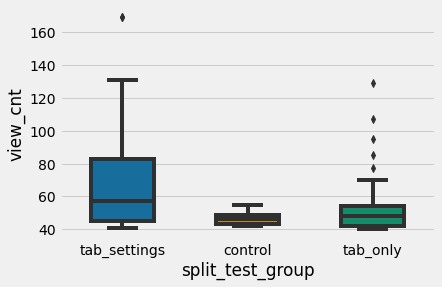

In [31]:
sns.boxplot(y='view_cnt', x='split_test_group', 
                 data=exp_result[exp_result.view_cnt>=40], 
                 width=0.5,
                 palette="colorblind");


In [32]:
# Define one tail TTtest
from scipy.stats import ttest_ind
def t_test(x,y,alternative='both-sided'):    
    _, double_p = ttest_ind(x,y,equal_var = False)
    diff=np.mean(x)-np.mean(y)
    if alternative == 'both-sided':
        pval = double_p
    elif alternative == 'greater':
        if np.mean(x) > np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    elif alternative == 'less':
        if np.mean(x) < np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    return pval, diff

In [33]:
TestSample1=exp_result[exp_result.split_test_group=='control'].view_cnt
TestSample2=exp_result[exp_result.split_test_group=='tab_only'].view_cnt
TestSample3=exp_result[exp_result.split_test_group=='tab_settings'].view_cnt
print(t_test(TestSample1,TestSample2,"less"));
print(t_test(TestSample1,TestSample3,"less"));
print(t_test(TestSample2,TestSample3,"greater"));


(7.106134624505105e-221, -0.37454692042802457)
(7.705778261996953e-124, -0.285000458815524)
(7.817464367730659e-10, 0.08954646161250057)


In [34]:
TestSample1=exp_result[exp_result.split_test_group=='control'].invite_cnt
TestSample2=exp_result[exp_result.split_test_group=='tab_only'].invite_cnt
TestSample3=exp_result[exp_result.split_test_group=='tab_settings'].invite_cnt

print(t_test(TestSample1,TestSample2,"less"));
print(t_test(TestSample1,TestSample3,"less"));
print(t_test(TestSample2,TestSample3,"greater"));


(2.4142301334246284e-15, -0.017440900968611797)
(4.874385812634304e-09, -0.01681836110251981)
(0.42872757850662135, 0.0006225398660919916)


In [48]:
TestSample1=exp_result[exp_result.split_test_group=='control'].view_to_invite_ratio
TestSample2=exp_result[exp_result.split_test_group=='tab_only'].view_to_invite_ratio
TestSample3=exp_result[exp_result.split_test_group=='tab_settings'].view_to_invite_ratio

print(t_test(TestSample1,TestSample2,"less"));
print(t_test(TestSample1,TestSample3,"less"));
print(t_test(TestSample2,TestSample3,"greater"));


(2.501517814681602e-13, -0.0036115901872589232)
(4.099031298918167e-14, -0.003876571513949118)
(0.6697525763366299, -0.00026498132669019493)


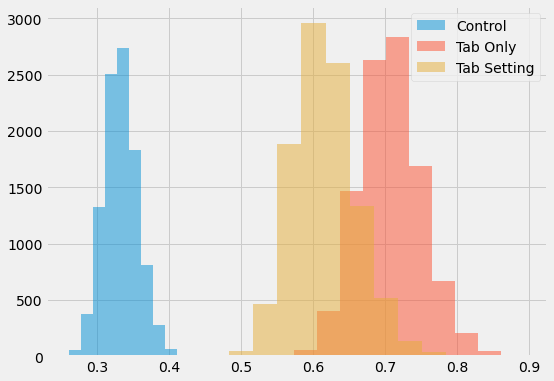

In [81]:
sample_data = exp_result.sample(1000)
# 1. Lets bootstrap using a subset of the data and note down means for control and treatment groups
mean_diff1 = []
mean_diff2 = []
mean_diff3 = []
tab_only_means = []
control_means = []
tab_settings_means = []
for _ in range (10000):
    bootstrap = exp_result.sample(1000, replace=True)
    controlmean = bootstrap[bootstrap.split_test_group=='control'].view_cnt.mean()
    treatmentmean = bootstrap[bootstrap.split_test_group=='tab_only'].view_cnt.mean()
    treatmentmean2 = bootstrap[bootstrap.split_test_group=='tab_settings'].view_cnt.mean()    
    control_means.append(controlmean)
    tab_only_means.append(treatmentmean)
    mean_diff1.append(treatmentmean - controlmean)
    mean_diff2.append(treatmentmean2 - controlmean)
    mean_diff3.append(treatmentmean2 - treatmentmean)    
    tab_settings_means.append(treatmentmean2)

#Lets plot this
plt.figure(figsize=(8,6))
plt.hist(control_means, alpha=0.5 ,label='Control');
plt.hist(tab_only_means, alpha=0.5,label='Tab Only');
plt.hist(tab_settings_means, alpha=0.5,label='Tab Setting');
plt.legend()

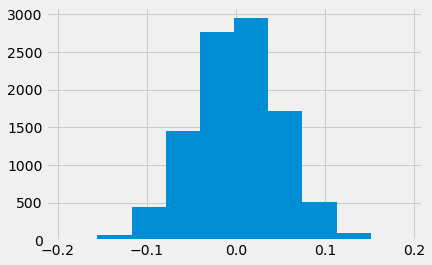

In [86]:
# 2. Lets' pick samples from the null.
null_val = np.random.normal(0, np.std(mean_diff1), 10000)
plt.hist(null_val);

In [91]:
#well test to see what proportion of the samples from #(2) are not equal to our sample mean.
(null_val==mean_diff1).mean()

0.0

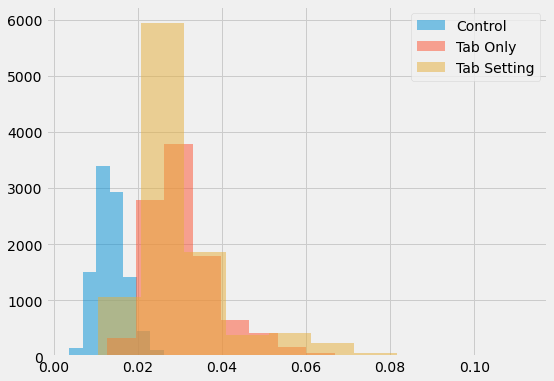

In [79]:
sample_data = exp_result.sample(10000)
# 1. Lets bootstrap using a subset of the data and note down means for control and treatment groups
mean_diff1 = []
mean_diff2 = []
mean_diff3 = []
tab_only_means = []
control_means = []
tab_settings_means = []
for _ in range (10000):
    bootstrap = exp_result.sample(10000, replace=True)
    controlmean = bootstrap[bootstrap.split_test_group=='control'].invite_cnt.mean()
    treatmentmean = bootstrap[bootstrap.split_test_group=='tab_only'].invite_cnt.mean()
    treatmentmean2 = bootstrap[bootstrap.split_test_group=='tab_settings'].invite_cnt.mean()   
    control_means.append(controlmean)
    tab_only_means.append(treatmentmean)
    mean_diff1.append(treatmentmean - controlmean)
    mean_diff2.append(treatmentmean2 - controlmean)
    mean_diff3.append(treatmentmean2 - treatmentmean)    
    tab_settings_means.append(treatmentmean2)

#Lets plot this
plt.figure(figsize=(8,6))
plt.hist(control_means, alpha=0.5 ,label='Control');
plt.hist(tab_only_means, alpha=0.5,label='Tab Only');
plt.hist(tab_settings_means, alpha=0.5,label='Tab Setting');
plt.legend()

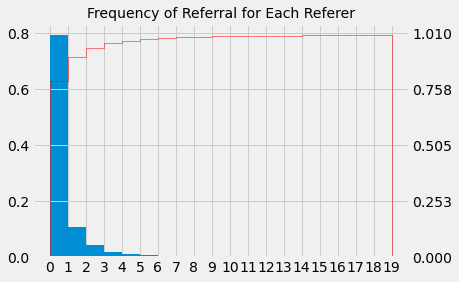

In [35]:
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()
plt.xticks(np.arange(0,20,1))
ax.hist(exp_result.view_cnt, bins=range(0, 20, 1), density=True)
ax1=ax.twinx() 
ax1.hist(exp_result.view_cnt, bins=range(0,20, 1), density=True, histtype='step', cumulative=1 ,color='red')
plt.title("Frequency of Referral for Each Referer",fontsize=14)
l = ax.get_ylim()
l1 = ax1.get_ylim()
f = lambda x : l1[0]+(x-l[0])/(l[1]-l[0])*(l1[1]-l1[0])
ticks = f(ax.get_yticks())
ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
plt.show(); 

In [36]:
# check how many user id in referrals are from event table
test=events[events.user_id.isin(referrals.referrer_user_id)]
test['user_id'].agg(['count','nunique'])

count      38904
nunique     1165
Name: user_id, dtype: int64

In [37]:
# check how many user id in events are from experiment table
test=split_test_exposures[split_test_exposures.user_id.isin(events.user_id)]
test['user_id'].agg(['count','nunique'])

count      44491
nunique    41732
Name: user_id, dtype: int64

In [38]:
# check how many referral data are from experiment table
test=split_test_exposures[split_test_exposures.user_id.isin(referrals.referrer_user_id)]
test.count()

user_id             187
split_test_name     187
split_test_group    187
exposed_time        187
dtype: int64